In [1]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 0.98 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41419,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:41613,Total threads: 8
Dashboard: http://127.0.0.1:44027/status,Memory: 62.93 GiB
Nanny: tcp://127.0.0.1:43297,


In [2]:
import xgcm
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
import cmocean.cm as cmo
from xmitgcm import open_mdsdataset

plt.rcParams['font.size'] = 15

In [3]:
filename_heat = 'diag_heat_budget'
filename_kpp = 'diag_kpp'
filename_mom_u = 'diag_mom_u'
filename_state = 'diag_state'
filename_surf = 'diag_surf'

zMin = -250
zMax = 0
lon = 220.0
latMin = -0.1
latMax = 0.1

data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_withhold/run_iter14/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state,filename_mom_u,filename_surf]
ds = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds['XC'] = ds.XC.astype(float)
ds['YC'] = ds.YC.astype(float)
ds['Z'] = ds.Z.astype(float)
ds['XG'] = ds.XG.astype(float)
ds['YG'] = ds.YG.astype(float)
ds['Zl'] = ds.Zl.astype(float)

data_dir = '/data/SO3/edavenport/tpose6/sep2012/velocity_assim/run_iter22/'
grid_dir = '/data/SO6/TPOSE_diags/tpose6/grid_6/'

num_diags = 122 #
itPerFile = 72 # 1 day
intervals = range(itPerFile,itPerFile*num_diags+1,itPerFile)

prefix = [filename_state,filename_mom_u,filename_surf]
ds_vel = open_mdsdataset(data_dir=data_dir,grid_dir=grid_dir,iters=intervals,prefix=prefix,ref_date='2012-09-01',delta_t=1200.,ignore_unknown_vars=True)

ds_vel['XC'] = ds.XC.astype(float)
ds_vel['YC'] = ds.YC.astype(float)
ds_vel['Z'] = ds.Z.astype(float)
ds_vel['XG'] = ds.XG.astype(float)
ds_vel['YG'] = ds.YG.astype(float)
ds_vel['Zl'] = ds.Zl.astype(float)

In [4]:
folder_name = '/home/edavenport/analysis/mitgcm-mombudg/velocity_assim/sep2012_UV_compare/'

In [5]:
grid = xgcm.Grid(ds, periodic=['X','Y'])
vol = (ds.rAw*ds.hFacW*ds.drF)
KPP_momU = grid.diff(ds.VISrI_Um,'Z',boundary='fill',fill_value=0)/vol
KPP_momU = KPP_momU.where(ds.hFacW.values > 0,0) # set any nan fluxes to 0
ds['Um_Advec'] = ds.Um_Advec - ds.Um_Cori

grid = xgcm.Grid(ds_vel, periodic=['X','Y'])
vol = (ds_vel.rAw*ds_vel.hFacW*ds_vel.drF)
KPP_momU_vel = grid.diff(ds_vel.VISrI_Um,'Z',boundary='fill',fill_value=0)/vol
KPP_momU_vel = KPP_momU_vel.where(ds_vel.hFacW.values > 0,0) # set any nan fluxes to 0
ds_vel['Um_Advec'] = ds_vel.Um_Advec - ds_vel.Um_Cori

In [6]:
decorr_scale_days = 5 # see DecorrelationScales_MBTerms.py
N_ind = (90)/decorr_scale_days # approximate number of days in a season
std_err_denom = np.sqrt(N_ind)

In [7]:
RHS = (KPP_momU.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') +  
    ds.Um_Advec.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') +  
    ds.Um_Cori.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') + 
    ds.Um_Ext.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') + 
    ds.Um_dPhiX.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') + 
    ds.AB_gU.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') + 
    ds.Um_Diss.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest')).squeeze()

TOTUTEND = ds.TOTUTEND.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze()/86400

RHS_vel = (KPP_momU_vel.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') +  
    ds_vel.Um_Advec.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') +  
    ds_vel.Um_Cori.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') + 
    ds_vel.Um_Ext.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') + 
    ds_vel.Um_dPhiX.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') + 
    ds_vel.AB_gU.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest') + 
    ds_vel.Um_Diss.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest')).squeeze()

TOTUTEND_vel = ds_vel.TOTUTEND.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze()/86400

In [8]:
Um_TOT = TOTUTEND.mean(dim='YC').mean(dim='time').compute()
Um_RHS = RHS.mean(dim='YC').mean(dim='time').compute()
Um_TOT_mean = TOTUTEND.mean(dim='YC').mean(dim='time').compute()
Um_RHS_mean = RHS.mean(dim='YC').mean(dim='time').compute()

Um_TOT_vel = TOTUTEND_vel.mean(dim='YC').mean(dim='time').compute()
Um_RHS_vel = RHS_vel.mean(dim='YC').mean(dim='time').compute()
Um_TOT_vel_mean = TOTUTEND_vel.mean(dim='YC').mean(dim='time').compute()
Um_RHS_vel_mean = RHS_vel.mean(dim='YC').mean(dim='time').compute()
# Um_TOT_std = TOTUTEND.std(dim='YC').std(dim='time').compute()/std_err_denom
# Um_RHS_std = RHS.std(dim='YC').std(dim='time').compute()/std_err_denom

/home/edavenport/miniconda3/envs/mitgcm_analysis/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/edavenport/miniconda3/envs/mitgcm_analysis/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/edavenport/miniconda3/envs/mitgcm_analysis/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/edavenport/miniconda3/envs/mitgcm_analysis/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/edavenport/miniconda3/envs/mitgcm_analysis/lib/python3.12/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cac

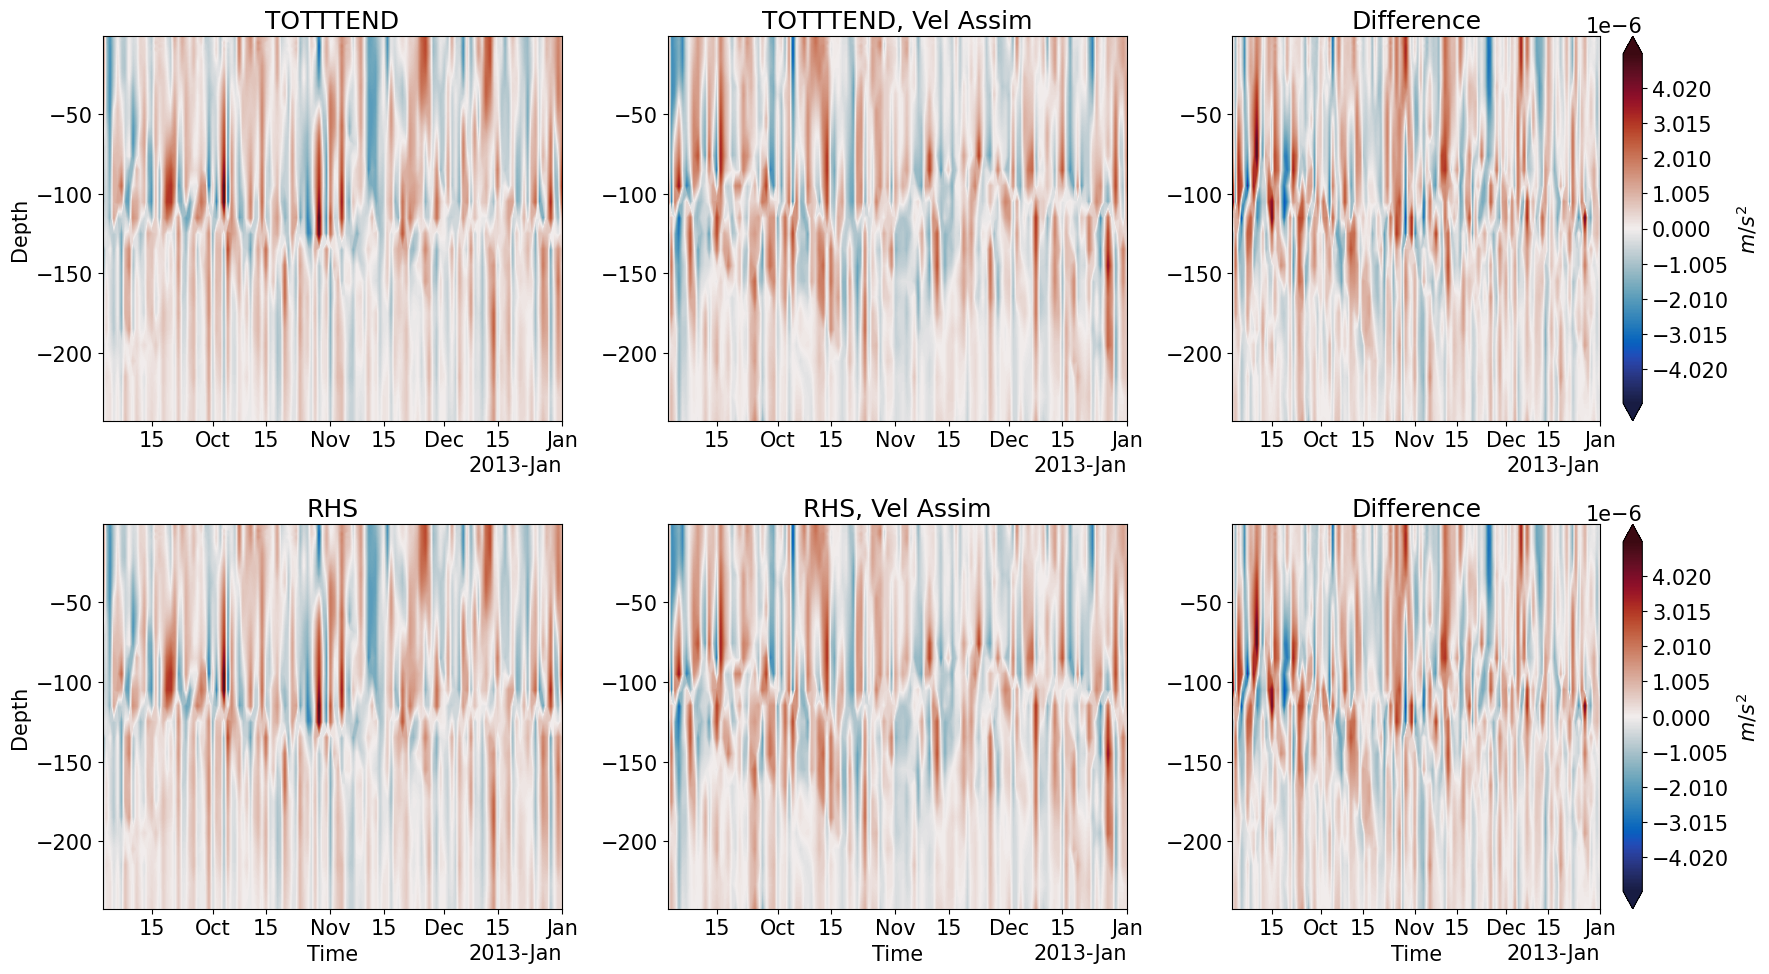

In [9]:
from matplotlib.colors import TwoSlopeNorm

vmin = -5e-6
vmax = 5e-6
levels = np.arange(vmin,vmax,0.5e-8)

fig, ax = plt.subplots(figsize=(18,10),nrows=2,ncols=3)
TOTUTEND.mean(dim='YC').plot.contourf(ax=ax[0,0],x='time',y='Z',levels=levels,cmap=cmo.balance,add_colorbar=False)
ax[0,0].set_title('TOTTTEND')
ax[0,0].set_xlabel('')
ax[0,0].set_ylabel('Depth')

RHS.mean(dim='YC').plot.contourf(ax=ax[1,0],x='time',y='Z',levels=levels,cmap=cmo.balance,add_colorbar=False)
ax[1,0].set_title('RHS')
ax[1,0].set_xlabel('Time')
ax[1,0].set_ylabel('Depth')

TOTUTEND_vel.mean(dim='YC').plot.contourf(ax=ax[0,1],x='time',y='Z',levels=levels,cmap=cmo.balance,add_colorbar=False)
ax[0,1].set_title('TOTTTEND, Vel Assim')
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel('')

RHS_vel.mean(dim='YC').plot.contourf(ax=ax[1,1],x='time',y='Z',levels=levels,cmap=cmo.balance,add_colorbar=False)
ax[1,1].set_title('RHS, Vel Assim')
ax[1,1].set_xlabel('Time')
ax[1,1].set_ylabel('')

(TOTUTEND_vel - TOTUTEND).mean(dim='YC').plot.contourf(ax=ax[0,2],x='time',y='Z',levels=levels,cmap=cmo.balance,cbar_kwargs={'label':'$m/s^2$'},norm=TwoSlopeNorm(vmin=vmin,vcenter=0,vmax=vmax))
ax[0,2].set_title('Difference')
ax[0,2].set_xlabel('')
ax[0,2].set_ylabel('')

(RHS_vel - RHS).mean(dim='YC').plot.contourf(ax=ax[1,2],x='time',y='Z',levels=levels,cmap=cmo.balance,cbar_kwargs={'label':'$m/s^2$'},norm=TwoSlopeNorm(vmin=vmin,vcenter=0,vmax=vmax))
ax[1,2].set_title('Difference')
ax[1,2].set_xlabel('Time')
ax[1,2].set_ylabel('')

plt.tight_layout()

fig.savefig(folder_name+'mombudget_closure_timeseries.png')

In [10]:
KPP_momU = KPP_momU.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
Um_Advec = ds.Um_Advec.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
Um_Ext = ds.Um_Ext.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
Um_dPhiX = ds.Um_dPhiX.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()

KPP_momU_ext = KPP_momU + Um_Ext

KPP_momU_mean = KPP_momU_ext.mean(dim='time').compute()
KPP_momU_std = KPP_momU_ext.std(dim='time').compute()/std_err_denom
Um_Advec_mean = Um_Advec.mean(dim='time').compute()
Um_Advec_std = Um_Advec.std(dim='time').compute()/std_err_denom
Um_dPhiX_mean = Um_dPhiX.mean(dim='time').compute()
Um_dPhiX_std = Um_dPhiX.std(dim='time').compute()/std_err_denom

In [11]:
KPP_momU_vel = KPP_momU_vel.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
Um_Advec_vel = ds_vel.Um_Advec.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
Um_Ext_vel = ds_vel.Um_Ext.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
Um_dPhiX_vel = ds_vel.Um_dPhiX.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()

KPP_momU_ext_vel = KPP_momU_vel + Um_Ext_vel

KPP_momU_vel_mean = KPP_momU_ext_vel.mean(dim='time').compute()
KPP_momU_vel_std = KPP_momU_ext_vel.std(dim='time').compute()/std_err_denom
Um_Advec_vel_mean = Um_Advec_vel.mean(dim='time').compute()
Um_Advec_vel_std = Um_Advec_vel.std(dim='time').compute()/std_err_denom
Um_dPhiX_vel_mean = Um_dPhiX_vel.mean(dim='time').compute()
Um_dPhiX_vel_std = Um_dPhiX_vel.std(dim='time').compute()/std_err_denom

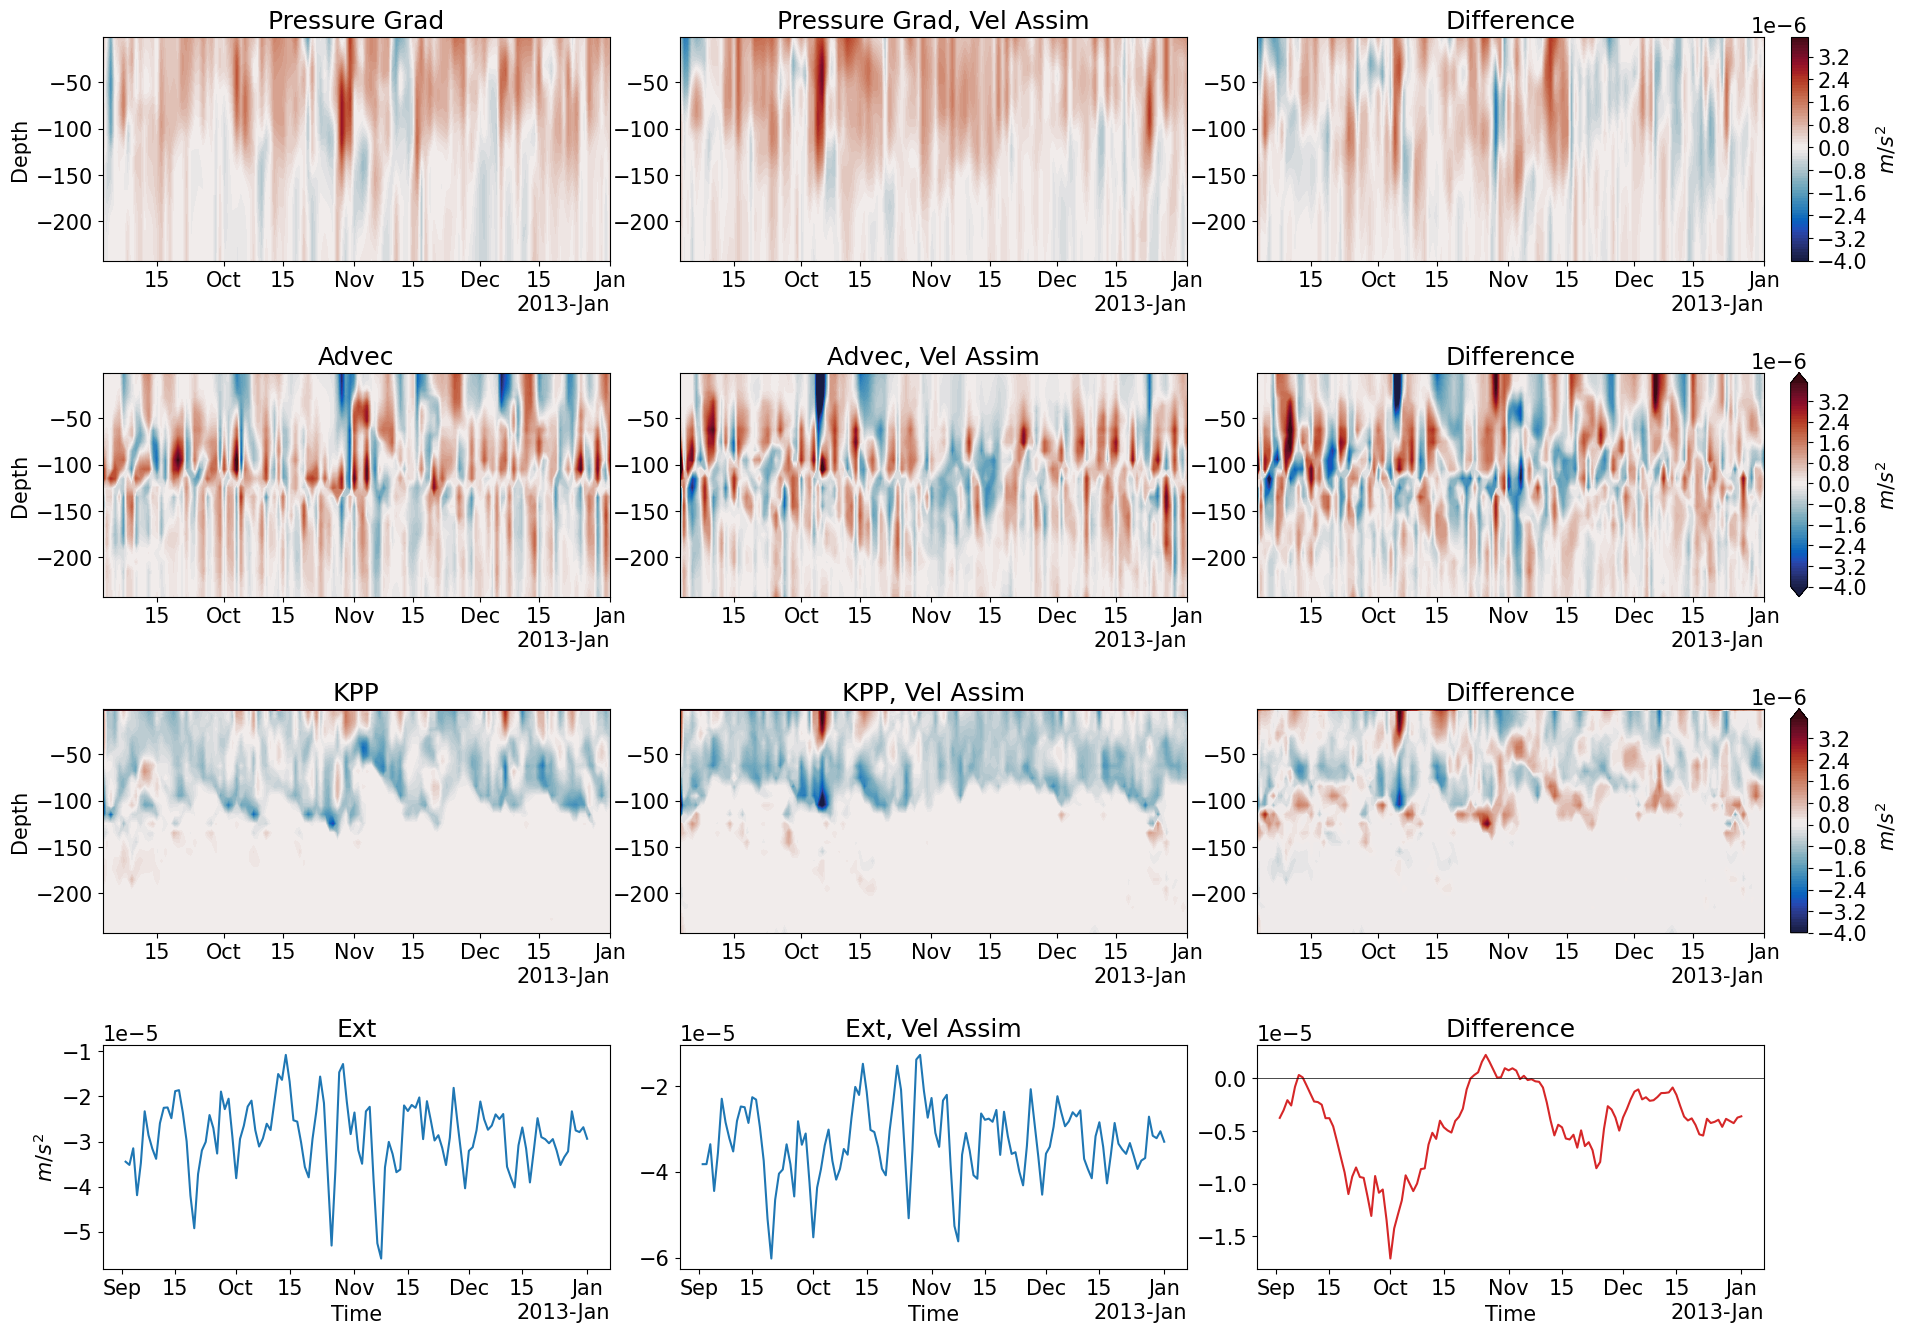

In [36]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.gridspec as gridspec
import numpy as np

vmin = -4e-6
vmax = 4e-6
levels = np.arange(vmin, vmax, 1e-7)

fig = plt.figure(figsize=(22, 16))
# Create a 4-row, 3-column grid: 1st column for plots, 2nd column for colorbars
gs = gridspec.GridSpec(4, 6, width_ratios=[30, 1, 30, 1, 30, 1], height_ratios=[1, 1, 1, 1], wspace=0.1, hspace=0.5)

# --- Row 1 ---
ax0 = fig.add_subplot(gs[0, 0])
# cax0 = fig.add_subplot(gs[0, 1])
Um_dPhiX.plot.contourf(ax=ax0, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax0.set_title('Pressure Grad')
ax0.set_xlabel('')
ax0.set_ylabel('Depth')

ax01 = fig.add_subplot(gs[0, 2])
# cax01 = fig.add_subplot(gs[0, 3])
Um_dPhiX_vel.plot.contourf(ax=ax01, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax01.set_title('Pressure Grad, Vel Assim')
ax01.set_xlabel('')
ax01.set_ylabel('')

ax02 = fig.add_subplot(gs[0, 4])
cax02 = fig.add_subplot(gs[0, 5])
(Um_dPhiX_vel - Um_dPhiX).plot.contourf(ax=ax02, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       cbar_ax=cax02, cbar_kwargs={'label': '$m/s^2$'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax02.set_title('Difference')
ax02.set_xlabel('')
ax02.set_ylabel('')

# --- Row 2 ---
ax1 = fig.add_subplot(gs[1, 0])
# cax1 = fig.add_subplot(gs[1, 1])
Um_Advec.plot.contourf(ax=ax1, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax1.set_title('Advec')
ax1.set_xlabel('')
ax1.set_ylabel('Depth')

ax11 = fig.add_subplot(gs[1, 2])
# cax11 = fig.add_subplot(gs[1, 3])
Um_Advec_vel.plot.contourf(ax=ax11, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax11.set_title('Advec, Vel Assim')
ax11.set_xlabel('')
ax11.set_ylabel('')

ax12 = fig.add_subplot(gs[1, 4])
cax12 = fig.add_subplot(gs[1, 5])
(Um_Advec_vel - Um_Advec).plot.contourf(ax=ax12, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       cbar_ax=cax12, cbar_kwargs={'label': '$m/s^2$'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax12.set_title('Difference')
ax12.set_xlabel('')
ax12.set_ylabel('')

# --- Row 3 ---
ax2 = fig.add_subplot(gs[2, 0])
# cax2 = fig.add_subplot(gs[2, 1])
KPP_momU.plot.contourf(ax=ax2, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax2.set_title('KPP')
ax2.set_xlabel('')
ax2.set_ylabel('Depth')

ax21 = fig.add_subplot(gs[2, 2])
# cax21 = fig.add_subplot(gs[2, 3])
KPP_momU_vel.plot.contourf(ax=ax21, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax21.set_title('KPP, Vel Assim')
ax21.set_xlabel('')
ax21.set_ylabel('')

ax22 = fig.add_subplot(gs[2, 4])
cax22 = fig.add_subplot(gs[2, 5])
(KPP_momU_vel - KPP_momU).plot.contourf(ax=ax22, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       cbar_ax=cax22, cbar_kwargs={'label': '$m/s^2$'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax22.set_title('Difference')
ax22.set_xlabel('')
ax22.set_ylabel('')

# --- Row 4 (no colorbar, but same width as others) ---
ax3 = fig.add_subplot(gs[3, 0])
Um_Ext.isel(Z=0).plot(ax=ax3, x='time')
ax3.set_title('Ext')
ax3.set_xlabel('Time')
ax3.set_ylabel('$m/s^2$')

ax31 = fig.add_subplot(gs[3, 2])
Um_Ext_vel.isel(Z=0).plot(ax=ax31, x='time')
ax31.set_title('Ext, Vel Assim')
ax31.set_xlabel('Time')
ax31.set_ylabel('')

ax32 = fig.add_subplot(gs[3, 4])
(Um_Ext_vel-Um_Ext).isel(Z=0).plot(ax=ax32, x='time',color='tab:red')
ax32.set_title('Difference')
ax32.axhline(0,color='black',linewidth=0.5)
ax32.set_xlabel('Time')
ax32.set_ylabel('')

# Leave gs[3,1] empty so width matches others
# fig.tight_layout()
plt.tight_layout()
fig.savefig(folder_name + 'mombudget_terms_timeseries.png')


In [13]:
uvel = ds.UVEL.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
EUC_Core = ds.Z[uvel.argmax(dim='Z')].mean(dim='time').compute()

uvel_vel = ds_vel.UVEL.sel(Z=slice(zMax,zMin),YC=slice(latMin,latMax)).sel(XG=[lon],method='nearest').squeeze().mean(dim='YC').compute()
EUC_Core_vel = ds_vel.Z[uvel_vel.argmax(dim='Z')].mean(dim='time').compute()

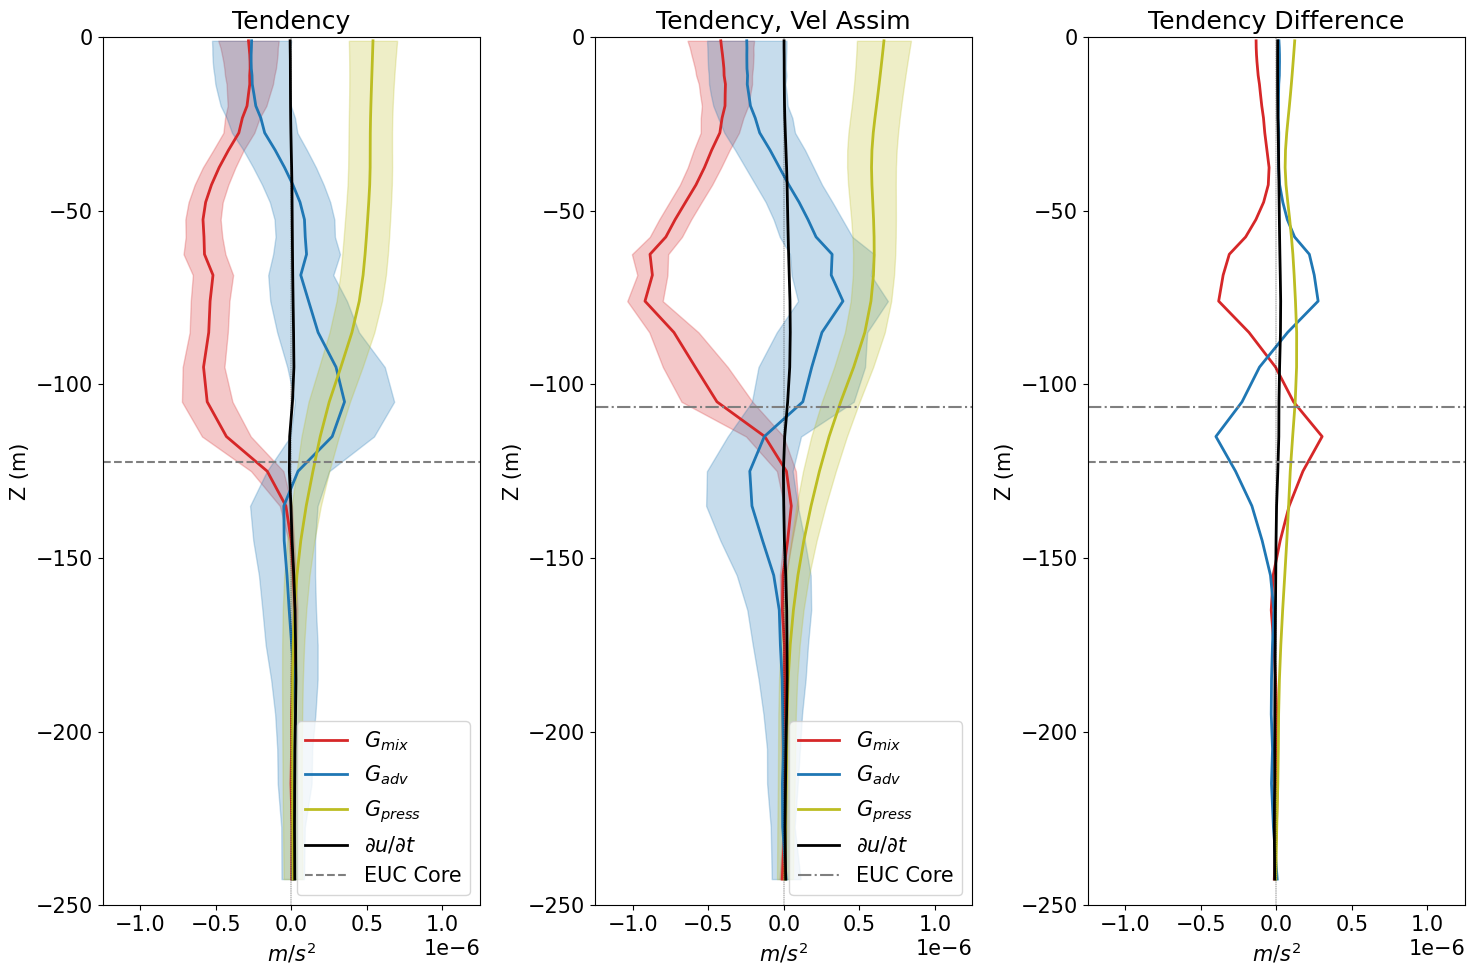

In [14]:
xmin = -1.25*(10**-6)
xmax = 1.25*(10**-6)

fig, ax = plt.subplots(figsize=(15,10), ncols=3)
KPP_momU_mean.plot(ax=ax[0],y='Z',linewidth=2.0,color='tab:red',label=r'$G_{mix}$')
ax[0].fill_betweenx(KPP_momU_mean.Z,KPP_momU_mean-KPP_momU_std,KPP_momU_mean+KPP_momU_std,color='tab:red',label='_nolegend_',alpha=0.25)
Um_Advec_mean.plot(ax=ax[0],y='Z',linewidth=2.0,color='tab:blue',label=r'$G_{adv}$')
ax[0].fill_betweenx(Um_Advec_mean.Z,Um_Advec_mean-Um_Advec_std,Um_Advec_mean+Um_Advec_std,color='tab:blue',label='_nolegend_',alpha=0.25)
Um_dPhiX_mean.plot(ax=ax[0],y='Z',linewidth=2.0,color='tab:olive',label=r'$G_{press}$')
ax[0].fill_betweenx(Um_dPhiX_mean.Z,Um_dPhiX_mean-Um_dPhiX_std,Um_dPhiX_mean+Um_dPhiX_std,color='tab:olive',label='_nolegend_',alpha=0.25)
Um_TOT_mean.plot(ax=ax[0],y='Z',linewidth=2.0,color='k',label=r'$\partial u/\partial t$')
ax[0].axvline(0,linestyle='--',linewidth=0.3,color='k')
ax[0].axhline(EUC_Core,linestyle='--',linewidth=1.5,color='tab:gray',label='EUC Core')
ax[0].set_ylim(zMin,0)
ax[0].set_xlim(xmin,xmax)
ax[0].legend(loc='lower right')
ax[0].set_title('Tendency')
ax[0].set_xlabel('$m/s^2$')
ax[0].set_ylabel('Z (m)')

KPP_momU_vel_mean.plot(ax=ax[1],y='Z',linewidth=2.0,color='tab:red',label=r'$G_{mix}$')
ax[1].fill_betweenx(KPP_momU_vel_mean.Z,KPP_momU_vel_mean-KPP_momU_vel_std,KPP_momU_vel_mean+KPP_momU_vel_std,color='tab:red',label='_nolegend_',alpha=0.25)
Um_Advec_vel_mean.plot(ax=ax[1],y='Z',linewidth=2.0,color='tab:blue',label=r'$G_{adv}$')
ax[1].fill_betweenx(Um_Advec_vel_mean.Z,Um_Advec_vel_mean-Um_Advec_vel_std,Um_Advec_vel_mean+Um_Advec_vel_std,color='tab:blue',label='_nolegend_',alpha=0.25)
Um_dPhiX_vel_mean.plot(ax=ax[1],y='Z',linewidth=2.0,color='tab:olive',label=r'$G_{press}$')
ax[1].fill_betweenx(Um_dPhiX_vel_mean.Z,Um_dPhiX_vel_mean-Um_dPhiX_vel_std,Um_dPhiX_vel_mean+Um_dPhiX_vel_std,color='tab:olive',label='_nolegend_',alpha=0.25)
Um_TOT_vel_mean.plot(ax=ax[1],y='Z',linewidth=2.0,color='k',label=r'$\partial u/\partial t$')
ax[1].axvline(0,linestyle='--',linewidth=0.3,color='k')
ax[1].axhline(EUC_Core_vel,linestyle='-.',linewidth=1.5,color='tab:gray',label='EUC Core')
ax[1].set_ylim(zMin,0)
ax[1].set_xlim(xmin,xmax)
ax[1].legend(loc='lower right')
ax[1].set_title('Tendency, Vel Assim')
ax[1].set_xlabel('$m/s^2$')
ax[1].set_ylabel('Z (m)')

KPP_diff = KPP_momU_vel_mean - KPP_momU_mean
Advec_diff = Um_Advec_vel_mean - Um_Advec_mean
dPhiX_diff = Um_dPhiX_vel_mean - Um_dPhiX_mean
TOT_diff = Um_TOT_vel_mean - Um_TOT_mean
KPP_diff.plot(ax=ax[2],y='Z',linewidth=2.0,color='tab:red',label=r'$G_{mix}$')
# ax[2].fill_betweenx(KPP_momU_mean.Z,KPP_momU_mean-KPP_momU_std,KPP_momU_mean+KPP_momU_std,color='tab:red',label='_nolegend_',alpha=0.25)
Advec_diff.plot(ax=ax[2],y='Z',linewidth=2.0,color='tab:blue',label=r'$G_{adv}$')
# ax[2].fill_betweenx(Um_Advec_mean.Z,Um_Advec_mean-Um_Advec_std,Um_Advec_mean+Um_Advec_std,color='tab:blue',label='_nolegend_',alpha=0.25)
dPhiX_diff.plot(ax=ax[2],y='Z',linewidth=2.0,color='tab:olive',label=r'$G_{press}$')
# ax[1].fill_betweenx(Um_dPhiX_mean.Z,Um_dPhiX_mean-Um_dPhiX_std,Um_dPhiX_mean+Um_dPhiX_std,color='tab:olive',label='_nolegend_',alpha=0.25)
TOT_diff.plot(ax=ax[2],y='Z',linewidth=2.0,color='k',label=r'$\partial u/\partial t$')
ax[2].axvline(0,linestyle='--',linewidth=0.3,color='k')
ax[2].axhline(EUC_Core,linestyle='--',linewidth=1.5,color='tab:gray',label='EUC Core')
ax[2].axhline(EUC_Core_vel,linestyle='-.',linewidth=1.5,color='tab:gray',label='EUC Core')
ax[2].set_ylim(zMin,0)
ax[2].set_xlim(xmin,xmax)
# ax[2].legend(loc='lower right')
ax[2].set_title('Tendency Difference')
ax[2].set_xlabel('$m/s^2$')
ax[2].set_ylabel('Z (m)')

plt.tight_layout()
fig.savefig(folder_name+'mombudget_terms_meanprof.png')

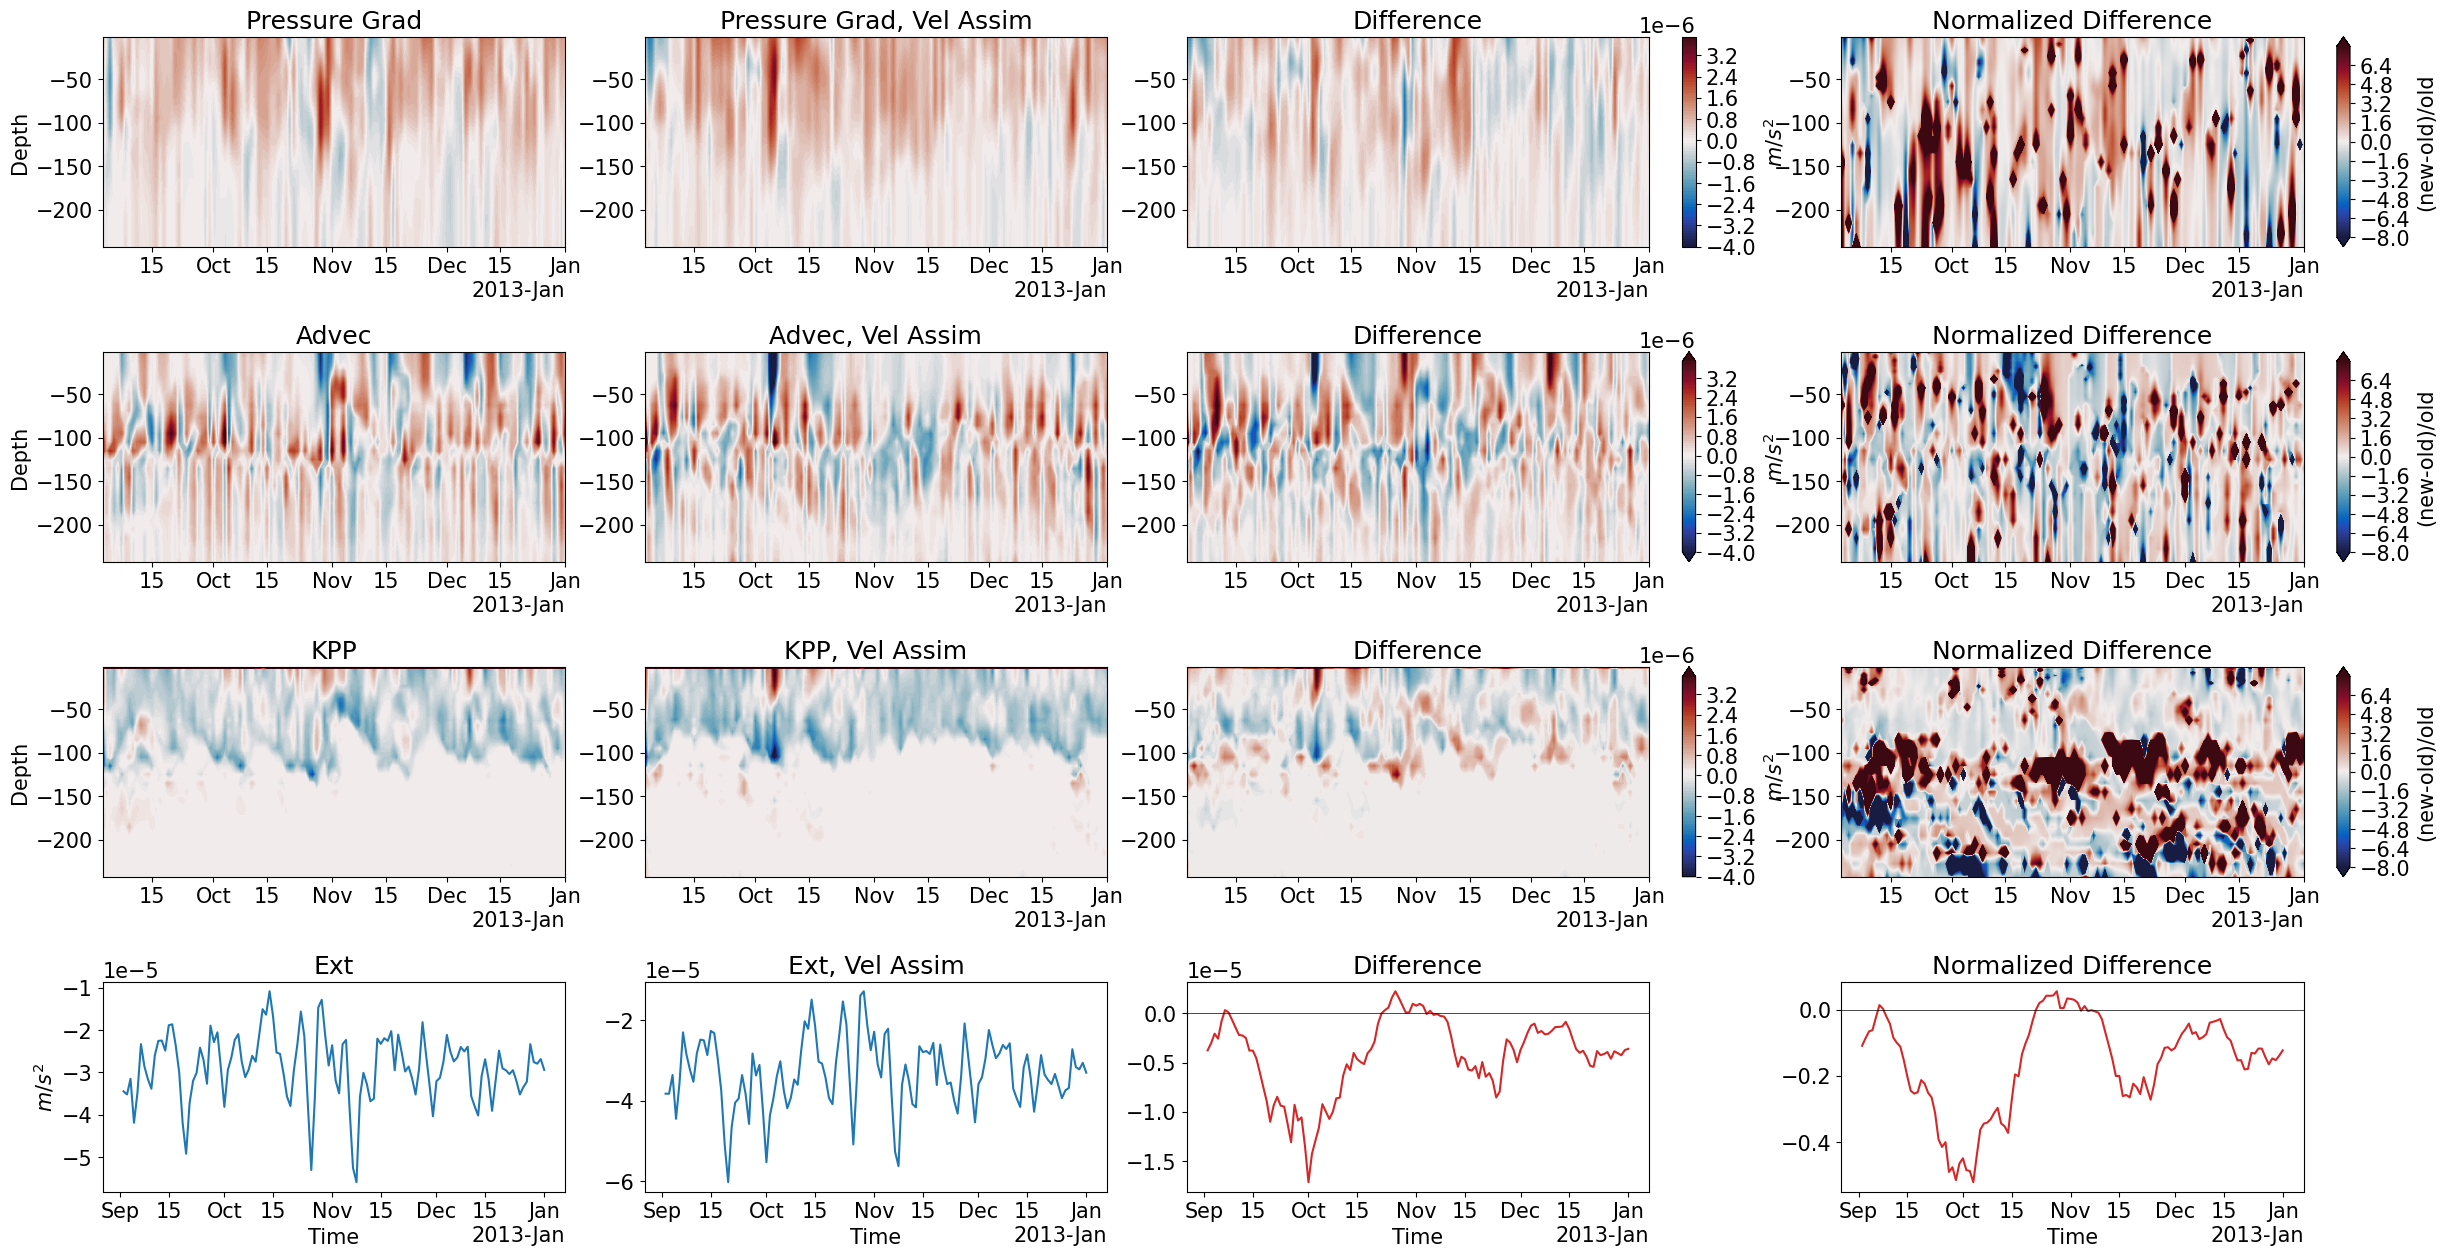

In [35]:
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import matplotlib.gridspec as gridspec
import numpy as np

vmin = -4e-6
vmax = 4e-6
levels = np.arange(vmin, vmax, 1e-7)

fig = plt.figure(figsize=(29, 15))
# Create a 4-row, 3-column grid: 1st column for plots, 2nd column for colorbars
gs = gridspec.GridSpec(4, 9, width_ratios=[35, 1, 35, 1, 35, 1 ,6, 35, 1], height_ratios=[1, 1, 1, 1], wspace=0.15, hspace=0.5)

# --- Row 1 ---
ax0 = fig.add_subplot(gs[0, 0])
# cax0 = fig.add_subplot(gs[0, 1])
Um_dPhiX.plot.contourf(ax=ax0, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax0.set_title('Pressure Grad')
ax0.set_xlabel('')
ax0.set_ylabel('Depth')

ax01 = fig.add_subplot(gs[0, 2])
# cax01 = fig.add_subplot(gs[0, 3])
Um_dPhiX_vel.plot.contourf(ax=ax01, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax01.set_title('Pressure Grad, Vel Assim')
ax01.set_xlabel('')
ax01.set_ylabel('')

ax02 = fig.add_subplot(gs[0, 4])
cax02 = fig.add_subplot(gs[0, 5])
(Um_dPhiX_vel - Um_dPhiX).plot.contourf(ax=ax02, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       cbar_ax=cax02, cbar_kwargs={'label': '$m/s^2$'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax02.set_title('Difference')
ax02.set_xlabel('')
ax02.set_ylabel('')

vmin = -8
vmax = 8
levels = np.arange(vmin, vmax, 0.01)
ax03 = fig.add_subplot(gs[0, 7])
cax03 = fig.add_subplot(gs[0, 8])
norm_diff = (Um_dPhiX_vel - Um_dPhiX)/np.abs(Um_dPhiX)
norm_diff.plot.contourf(ax=ax03, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       cbar_ax=cax03, cbar_kwargs={'label': '(new-old)/old'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax03.set_title('Normalized Difference')
ax03.set_xlabel('')
ax03.set_ylabel('')

# --- Row 2 ---
vmin = -4e-6
vmax = 4e-6
levels = np.arange(vmin, vmax, 1e-7)
ax1 = fig.add_subplot(gs[1, 0])
# cax1 = fig.add_subplot(gs[1, 1])
Um_Advec.plot.contourf(ax=ax1, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax1.set_title('Advec')
ax1.set_xlabel('')
ax1.set_ylabel('Depth')

ax11 = fig.add_subplot(gs[1, 2])
# cax11 = fig.add_subplot(gs[1, 3])
Um_Advec_vel.plot.contourf(ax=ax11, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax11.set_title('Advec, Vel Assim')
ax11.set_xlabel('')
ax11.set_ylabel('')

ax12 = fig.add_subplot(gs[1, 4])
cax12 = fig.add_subplot(gs[1, 5])
(Um_Advec_vel - Um_Advec).plot.contourf(ax=ax12, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       cbar_ax=cax12, cbar_kwargs={'label': '$m/s^2$'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax12.set_title('Difference')
ax12.set_xlabel('')
ax12.set_ylabel('')

vmin = -8
vmax = 8
levels = np.arange(vmin, vmax, 0.01)
ax13 = fig.add_subplot(gs[1, 7])
cax13 = fig.add_subplot(gs[1, 8])
norm_diff = (Um_Advec_vel - Um_Advec)/np.abs(Um_Advec)
norm_diff.plot.contourf(ax=ax13, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       cbar_ax=cax13, cbar_kwargs={'label': '(new-old)/old'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax13.set_title('Normalized Difference')
ax13.set_xlabel('')
ax13.set_ylabel('')

# --- Row 3 ---
vmin = -4e-6
vmax = 4e-6
levels = np.arange(vmin, vmax, 1e-7)
ax2 = fig.add_subplot(gs[2, 0])
# cax2 = fig.add_subplot(gs[2, 1])
KPP_momU.plot.contourf(ax=ax2, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax2.set_title('KPP')
ax2.set_xlabel('')
ax2.set_ylabel('Depth')

ax21 = fig.add_subplot(gs[2, 2])
# cax21 = fig.add_subplot(gs[2, 3])
KPP_momU_vel.plot.contourf(ax=ax21, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       add_colorbar=False,
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax21.set_title('KPP, Vel Assim')
ax21.set_xlabel('')
ax21.set_ylabel('')

ax22 = fig.add_subplot(gs[2, 4])
cax22 = fig.add_subplot(gs[2, 5])
(KPP_momU_vel - KPP_momU).plot.contourf(ax=ax22, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       cbar_ax=cax22, cbar_kwargs={'label': '$m/s^2$'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax22.set_title('Difference')
ax22.set_xlabel('')
ax22.set_ylabel('')

vmin = -8
vmax = 8
levels = np.arange(vmin, vmax, 0.01)
ax23 = fig.add_subplot(gs[2, 7])
cax23 = fig.add_subplot(gs[2, 8])
norm_diff = (KPP_momU_vel - KPP_momU)/np.abs(KPP_momU_vel)
norm_diff.plot.contourf(ax=ax23, x='time', y='Z', levels=levels, cmap=cmo.balance,
                       cbar_ax=cax23, cbar_kwargs={'label': '(new-old)/old'},
                       norm=TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax))
ax23.set_title('Normalized Difference')
ax23.set_xlabel('')
ax23.set_ylabel('')

# --- Row 4 (no colorbar, but same width as others) ---
ax3 = fig.add_subplot(gs[3, 0])
Um_Ext.isel(Z=0).plot(ax=ax3, x='time')
ax3.set_title('Ext')
ax3.set_xlabel('Time')
ax3.set_ylabel('$m/s^2$')

ax31 = fig.add_subplot(gs[3, 2])
Um_Ext_vel.isel(Z=0).plot(ax=ax31, x='time')
ax31.set_title('Ext, Vel Assim')
ax31.set_xlabel('Time')
ax31.set_ylabel('')

ax32 = fig.add_subplot(gs[3, 4])
(Um_Ext_vel-Um_Ext).isel(Z=0).plot(ax=ax32, x='time',color='tab:red')
ax32.set_title('Difference')
ax32.axhline(0,color='black',linewidth=0.5)
ax32.set_xlabel('Time')
ax32.set_ylabel('')

ax33 = fig.add_subplot(gs[3, 7])
norm_diff = (Um_Ext_vel-Um_Ext)/np.abs(Um_Ext)
norm_diff.isel(Z=0).plot(ax=ax33, x='time',color='tab:red')
ax33.set_title('Normalized Difference')
ax33.axhline(0,color='black',linewidth=0.5)
ax33.set_xlabel('Time')
ax33.set_ylabel('')

# Leave gs[3,1] empty so width matches others
# fig.tight_layout()
fig.tight_layout()
fig.savefig(folder_name + 'mombudget_terms_timeseries_2.png')


In [20]:
cluster.close()
client.shutdown()
client.close()